In [1]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv

In [2]:
model = xrv.baseline_models.chestx_det.PSPNet()

In [3]:
import skimage.io
import torchvision
import torch
import torchxrayvision as xrv

# Load the image
img = skimage.io.imread("../static/img/0c7a38f293d5f5e4846aa4ca6db4daf1.png")
# print("Original shape:", img.shape)  # Check the shape of the loaded image

# Normalize the image
img = xrv.datasets.normalize(img, 255)

# If the image is 2D (grayscale), add an extra dimension to make it (height, width, 1)
if img.ndim == 2:
    img = img[:, :, None]

# If the image has 4 channels (RGBA), discard the alpha channel
if img.shape[2] == 4:
    img = img[:, :, :3]
# print("Shape after ensuring 3 dimensions:", img.shape)

# Transpose the image to move the channel dimension to the first position (1, height, width)
img = img.transpose((2, 0, 1))
# print("Shape after transposing:", img.shape)

# Apply the transforms
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512)
])
img = transform(img)

# Convert the image to a PyTorch tensor
img = torch.from_numpy(img)

# Print the final shape of the image
# print("Final shape:", img.shape)

In [4]:
with torch.no_grad():
    pred = model(img)

In [5]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

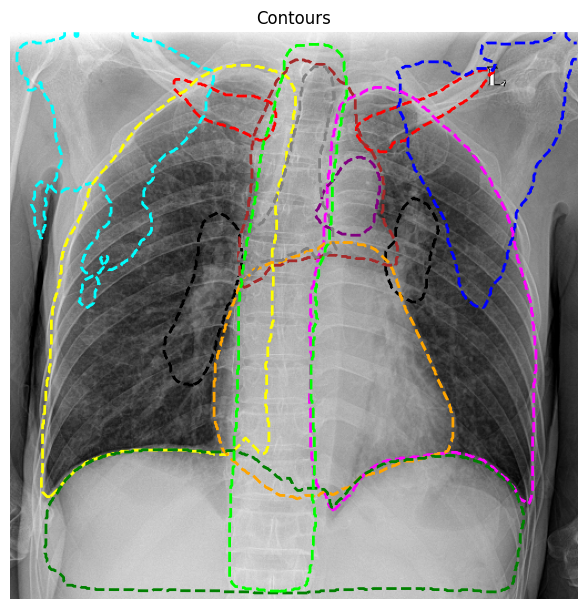

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours

# Assuming 'img' is the original image and 'pred' is the predicted masks
# 'img' should be a 3D numpy array (channels, height, width)
# 'pred' should be a 4D numpy array (batch, classes, height, width)

# Create a figure
plt.figure(figsize=(12, 6))

# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)

# Indices for the masks you want to combine
target_indices = list(range(14))  # Indices for the masks

# Custom colors for each contour
contour_colors = ['red', 'red', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'black',
                  'orange', 'purple', 'green', 'brown', 'gray', 'lime']

# Plot the combined contours on a transparent background
plt.subplot(1, 2, 2)
plt.imshow(img[0], cmap='gray')
plt.title('Contours')
plt.axis('off')

# Iterate through the predicted masks and plot each contour separately
for idx, i in enumerate(target_indices):
    mask = pred[0, i]
    combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask

    # Find and plot the contours of the mask
    contours = find_contours(combined_mask, level=idx + 0.1)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=2,  color=contour_colors[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

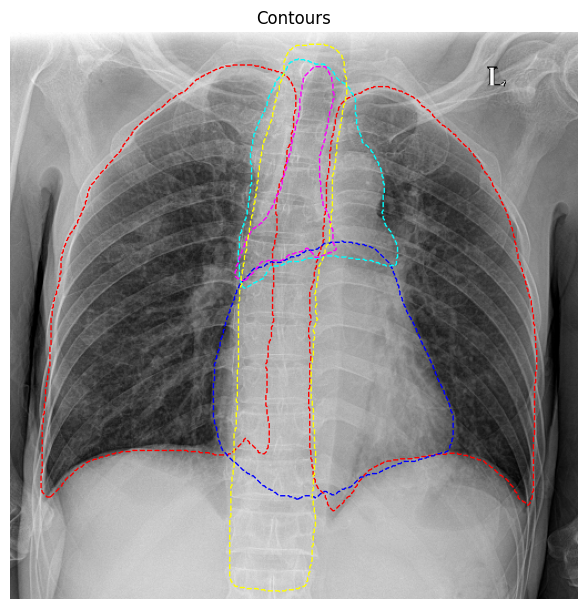

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours

# Assuming 'img' is the original image and 'pred' is the predicted masks
# 'img' should be a 3D numpy array (channels, height, width)
# 'pred' should be a 4D numpy array (batch, classes, height, width)

# Create a figure
plt.figure(figsize=(12, 6))

# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)

# Indices for the masks you want to combine
target_indices = list(range(14))  # Indices for the masks

# Custom colors for each contour
contour_colors = ['red', 'red', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'black',
                  'orange', 'purple', 'green', 'brown', 'gray', 'lime']

# Plot the combined contours on a transparent background
plt.subplot(1, 2, 2)
plt.imshow(img[0], cmap='gray')
plt.title('Contours')
plt.axis('off')

# Indices for the masks you want to combine
target_indices = [4,5,8,11, 12, 13]  # Indices for left lung, right lung, and heart

# Iterate through the predicted masks and combine them
for idx, i in enumerate(target_indices):
    mask = pred[0, i]
    combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask

    # Find and plot the contours of the mask
    contours = find_contours(combined_mask, level=idx + 0.1)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=1,  color=contour_colors[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

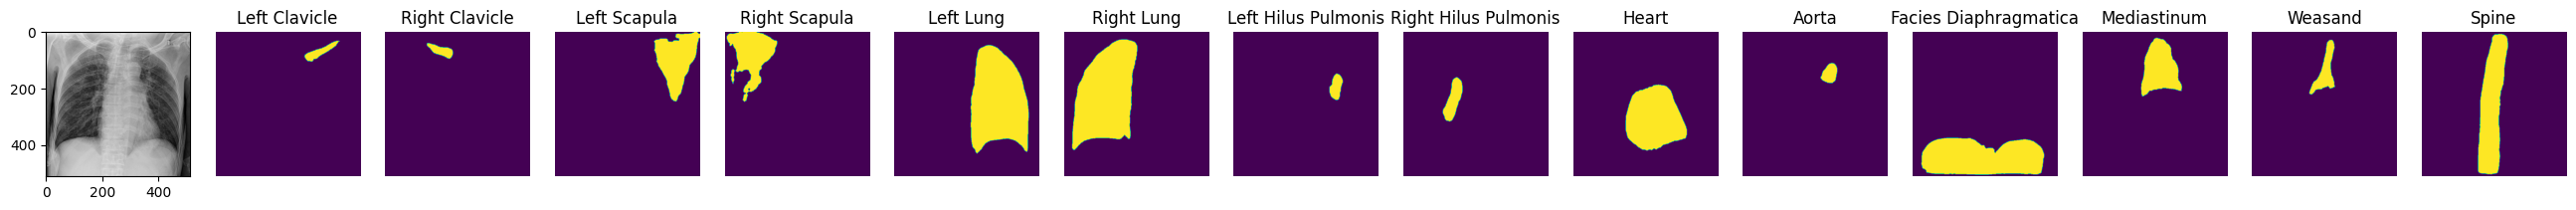

In [8]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    plt.imshow(pred[0, i])
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

Đường kính tim tối đa: 233.0 px
Đường kính phổi tối đa: 390.0 px
Đường kính trung thất tối đa: 207.0 px
Đường kính động mạch chủ tối đa: 71.0 px
Tỉ lệ tim ngực (CTR): 0.60


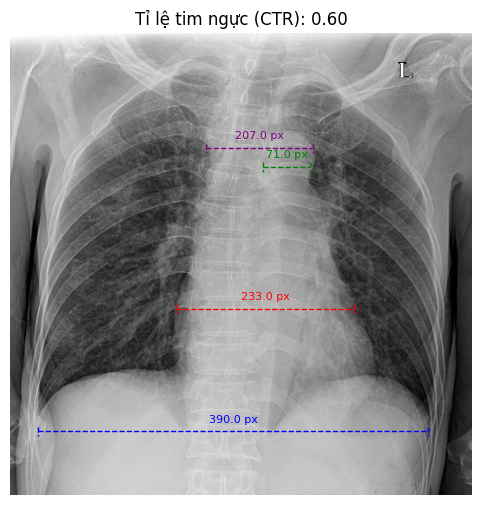

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

# Assuming 'img' is the original image and 'pred' is the predicted masks
# 'img' should be a 3D numpy array (channels, height, width)
# 'pred' should be a 4D numpy array (batch, classes, height, width)

# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)


# Step 1: Calculate maximum horizontal diameters
def measure_maximum_diameter(mask):
    contours = find_contours(mask, level=0.5)
    max_diameter = 0
    for contour in contours:
        max_y, min_y = contour[:, 0].max(), contour[:, 0].min()  # Calculate max and min y-coordinates
        diameter = max_y - min_y
        if diameter > max_diameter:
            max_diameter = diameter
    return max_diameter

left_lung_mask = pred[0, 4].numpy()
right_lung_mask = pred[0, 5].numpy()
heart_mask = pred[0, 8].numpy()
aorta_mask = pred[0, 9].numpy()
diaphramatica_mask = pred[0, 10].numpy()
media_mask = pred[0, 11].numpy()


heart_max_diameter = measure_maximum_diameter(heart_mask)
lung_combined_mask = np.logical_or(left_lung_mask, right_lung_mask)
lung_max_diameter = measure_maximum_diameter(lung_combined_mask)
diaphramatica_max_diameter = measure_maximum_diameter(diaphramatica_mask)
media_max_diameter = measure_maximum_diameter(media_mask)
aorta_max_diameter = measure_maximum_diameter(aorta_mask)

# Step 2: Calculate CTR
CTR = heart_max_diameter / lung_max_diameter

print("Đường kính tim tối đa:", heart_max_diameter,"px")
print("Đường kính phổi tối đa:",lung_max_diameter,"px")
print("Đường kính trung thất tối đa:", media_max_diameter,"px")
print("Đường kính động mạch chủ tối đa:", aorta_max_diameter,"px")

# Print the original and adjusted values
print(f"Tỉ lệ tim ngực (CTR): {CTR:.2f}")
# print(f"Adjusted Cardiothoracic Ratio (CTR) with error margin: {CTR_Adjusted:.2f}")

# Find the contours of the heart, left lung, and diaphramatica
heart_contours = find_contours(heart_mask, level=0.5)
diaphramatica_contours = find_contours(diaphramatica_mask, level=0.5)
aorta_contours = find_contours(aorta_mask, level=0.5)
media_contours = find_contours(media_mask, level=0.5)

# Find the bounding boxes of the heart, left lung, and diaphramatica
heart_x_min, heart_x_max, heart_y_min, heart_y_max = float('inf'), 0, float('inf'), 0
diaphramatica_x_min, diaphramatica_x_max, diaphramatica_y_min, diaphramatica_y_max = float('inf'), 0, float('inf'), 0
aorta_x_min, aorta_x_max, aorta_y_min, aorta_y_max = float('inf'), 0, float('inf'), 0
media_x_min, media_x_max, media_y_min, media_y_max = float('inf'), 0, float('inf'), 0

for contour in heart_contours:
    x = contour[:, 1]
    y = contour[:, 0]
    heart_x_min = min(heart_x_min, min(x))
    heart_x_max = max(heart_x_max, max(x))
    heart_y_min = min(heart_y_min, min(y))
    heart_y_max = max(heart_y_max, max(y))


for contour in diaphramatica_contours:
    x = contour[:, 1]
    y = contour[:, 0]
    diaphramatica_x_min = min(diaphramatica_x_min, min(x))
    diaphramatica_x_max = max(diaphramatica_x_max, max(x))
    diaphramatica_y_min = min(diaphramatica_y_min, min(y))
    diaphramatica_y_max = max(diaphramatica_y_max, max(y))


for contour in media_contours:
    x = contour[:, 1]
    y = contour[:, 0]
    media_x_min = min(media_x_min, min(x))
    media_x_max = max(media_x_max, max(x))
    media_y_min = min(media_y_min, min(y))
    media_y_max = max(media_y_max, max(y))


for contour in aorta_contours:
    x = contour[:, 1]
    y = contour[:, 0]
    aorta_x_min = min(aorta_x_min, min(x))
    aorta_x_max = max(aorta_x_max, max(x))
    aorta_y_min = min(aorta_y_min, min(y))
    aorta_y_max = max(aorta_y_max, max(y))

# Calculate the vertical centers of the heart, left lung, and diaphramatica
heart_y_center = (heart_y_min + heart_y_max) // 2
diaphramatica_y_center = (diaphramatica_y_min + diaphramatica_y_max) // 2
media_y_center = (media_y_min + media_y_max) // 2
aorta_y_center = (aorta_y_min + aorta_y_max) // 2

# Plot the original image with the horizontal lines inside the organs and the organ contours
plt.figure(figsize=(6, 6))
plt.imshow(img[0], cmap='gray')

# # Plot the aorta contour
# for contour in aorta_contours:
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green',linestyle='--')

# # Plot the heart contour
# for contour in heart_contours:
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='r',linestyle='--')

# # Plot the diaphramatica contour
# for contour in diaphramatica_contours:
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='b',linestyle='--')

# # Plot the media contour
# for contour in media_contours:
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='purple',linestyle='--')


# Plot the horizontal line inside the heart, but stop at the contour
# Vẽ đường ngang bên trong trái tim, nhưng dừng lại ở đường viền
for contour in heart_contours:
    # Find the intersection points between the horizontal line and the contour
    intersection_points = np.array([point for point in contour if point[0] == heart_y_center])

    # Draw the horizontal line up to the intersection points
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))

        # Draw the horizontal line
        plt.axhline(y=heart_y_center, color='r', linestyle='--', linewidth=1, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])

        # Draw the vertical line segments at the start and end points
        plt.plot([x_start, x_start], [heart_y_center - 5, heart_y_center + 5], color='r', linestyle='--', linewidth=1)
        plt.plot([x_end, x_end], [heart_y_center - 5, heart_y_center + 5], color='r', linestyle='--', linewidth=1)

        # Add the text label
        plt.text(x_start + (x_end - x_start) / 2, heart_y_center - 10, f"{heart_max_diameter} px", color='r', fontsize=8, ha='center')

# Plot the horizontal line inside the diaphramatica, but stop at the contour
# Vẽ đường ngang bên trong cơ hoành, nhưng dừng lại ở đường viền
for contour in diaphramatica_contours:
    # Find the intersection points between the horizontal line and the contour
    intersection_points = np.array([point for point in contour if point[0] == diaphramatica_y_center])

    # Draw the horizontal line up to the intersection points
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=diaphramatica_y_center, color='blue', linestyle='--', linewidth=1, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])

        # Draw the vertical line segments at the start and end points
        plt.plot([x_start, x_start], [diaphramatica_y_center - 5, diaphramatica_y_center + 5], color='blue', linestyle='--', linewidth=1)
        plt.plot([x_end, x_end], [diaphramatica_y_center - 5, diaphramatica_y_center + 5], color='blue', linestyle='--', linewidth=1)

        plt.text(x_start + (x_end - x_start) / 2, diaphramatica_y_center-10, f"{lung_max_diameter} px", color='blue', fontsize=8, ha='center')

# Vẽ đường ngang bên trong động mạch chủ, nhưng dừng lại ở đường viền
for contour in aorta_contours:
    # Find the intersection points between the horizontal line and the contour
    intersection_points = np.array([point for point in contour if point[0] == aorta_y_center])

    # Draw the horizontal line up to the intersection points
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=aorta_y_center, color='green', linestyle='--', linewidth=1, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])

        # Draw the vertical line segments at the start and end points
        plt.plot([x_start, x_start], [aorta_y_center - 5, aorta_y_center + 5], color='green', linestyle='--', linewidth=1)
        plt.plot([x_end, x_end], [aorta_y_center - 5, aorta_y_center + 5], color='green', linestyle='--', linewidth=1)

        plt.text(x_start + (x_end - x_start) / 2, aorta_y_center-10, f"{aorta_max_diameter} px", color='green', fontsize=8, ha='center')

# Vẽ đường ngang bên trong trung thất, nhưng dừng lại ở đường viền
for contour in media_contours:
    # Find the intersection points between the horizontal line and the contour
    intersection_points = np.array([point for point in contour if point[0] == media_y_center])

    # Draw the horizontal line up to the intersection points
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=media_y_center, color='purple', linestyle='--', linewidth=1, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])

        # Draw the vertical line segments at the start and end points
        plt.plot([x_start, x_start], [media_y_center - 5, media_y_center + 5], color='purple', linestyle='--', linewidth=1)
        plt.plot([x_end, x_end], [media_y_center - 5, media_y_center + 5], color='purple', linestyle='--', linewidth=1)

        plt.text(x_start + (x_end - x_start) / 2, media_y_center-10, f"{media_max_diameter} px", color='purple', fontsize=8, ha='center')

plt.title(f"Tỉ lệ tim ngực (CTR): {CTR:.2f}")
plt.axis('off')
plt.show()

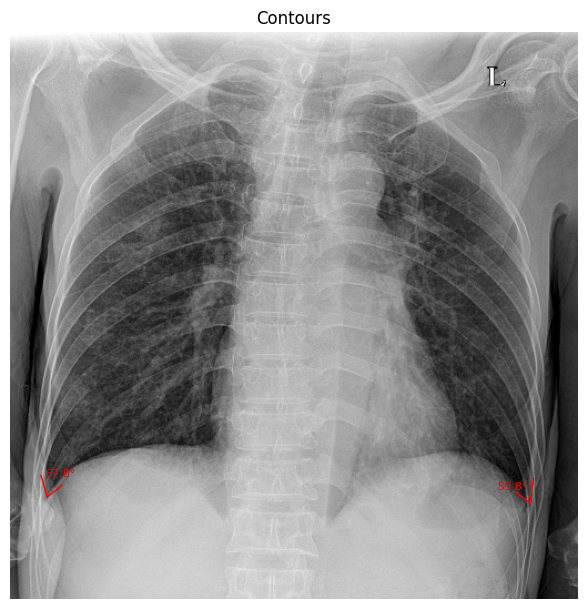

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle between three points.
    p1: intersection point
    p2: point on the lung boundary
    p3: another point on the lung boundary
    """
    vector1 = np.array(p2) - np.array(p1)
    vector2 = np.array(p3) - np.array(p1)
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)

# Assuming 'img' is the original image and 'pred' is the predicted masks
# 'img' should be a 3D numpy array (channels, height, width)
# 'pred' should be a 4D numpy array (batch, classes, height, width)

# Create a figure
plt.figure(figsize=(12, 6))

# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)

# Plot the combined contours on a transparent background
plt.subplot(1, 2, 2)
plt.imshow(img[0], cmap='gray')
plt.title('Contours')
plt.axis('off')

# Indices for the masks you want to combine
target_indices = [4,5]  # Indices for left lung

# Iterate through the predicted masks and combine them
for idx, i in enumerate(target_indices):
    if(i == 4):
      mask = pred[0, i]
      combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask
      # Find and plot the contours of the mask
      contours = find_contours(combined_mask, level=idx + 0.1)
      for contour in contours:
          # plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=1, color=contour_colors[idx])

          # Find the bottom right point and its neighbors
          bottom_right_idx = np.argmax(contour[:, 1] + contour[:, 0])
          point1 = contour[bottom_right_idx]  # Bottom right point
          point2 = contour[(bottom_right_idx - 25) % len(contour)]  # Adjust distance as needed
          point3 = contour[(bottom_right_idx + 25) % len(contour)]  # Adjust distance as needed


          # Calculate the angle
          angle = calculate_angle(point1, point2, point3)

          # Draw lines connecting the points
          plt.plot([point1[1], point2[1]], [point1[0], point2[0]], 'r-',linewidth=1)
          plt.plot([point1[1], point3[1]], [point1[0], point3[0]], 'r-',linewidth=1)
          # Calculate midpoints
          mid_x1, mid_y1 = (point1[1] + point2[1]) / 2, (point1[0] + point2[0]) / 2
          mid_x2, mid_y2 = (point1[1] + point3[1]) / 2, (point1[0] + point3[0]) / 2

          plt.text(mid_x2-10, mid_y2-10, f'{angle:.1f}°', color='r', fontsize=8, ha='center', va='center')

    else:
          mask = pred[0, i]
          combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask
          # Find and plot the contours of the mask
          contours = find_contours(combined_mask, level=idx + 0.1)
          for contour in contours:
              # plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=1, color=contour_colors[idx])
              # Find the bottom left point and its neighbors
              bottom_left_idx = np.argmin(contour[:, 1] - contour[:, 0])
              point4 = contour[bottom_left_idx]  # Bottom left point
              point5 = contour[(bottom_left_idx - 25) % len(contour)]  # Adjust distance as needed
              point6 = contour[(bottom_left_idx + 25) % len(contour)]  # Adjust distance as needed

              # Calculate the angle
              angle = calculate_angle(point4, point5, point6)

              # Draw lines connecting the points
              plt.plot([point4[1], point5[1]], [point4[0], point5[0]], 'r-',linewidth=1)
              plt.plot([point4[1], point6[1]], [point4[0], point6[0]], 'r-',linewidth=1)

              # Calculate midpoints
              mid_x1, mid_y1 = (point4[1] + point5[1]) / 2, (point4[0] + point5[0]) / 2
              mid_x2, mid_y2 = (point4[1] + point6[1]) / 2, (point4[0] + point6[0]) / 2

              # Add angle measurement next to the lines
              # plt.text(mid_x1, mid_y1, f'{angle:.1f}°', color='blue', fontsize=10, ha='center', va='center')
              plt.text(mid_x2+15, mid_y2-12, f'{angle:.1f}°', color='r', fontsize=8, ha='center', va='center')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Đường kính tim tối đa: 233.0 px
Đường kính phổi tối đa: 390.0 px
Đường kính trung thất tối đa: 207.0 px
Đường kính động mạch chủ tối đa: 71.0 px
Tỉ lệ trung thất (MR): 0.53
Tỉ lệ tim ngực (CTR): 0.60


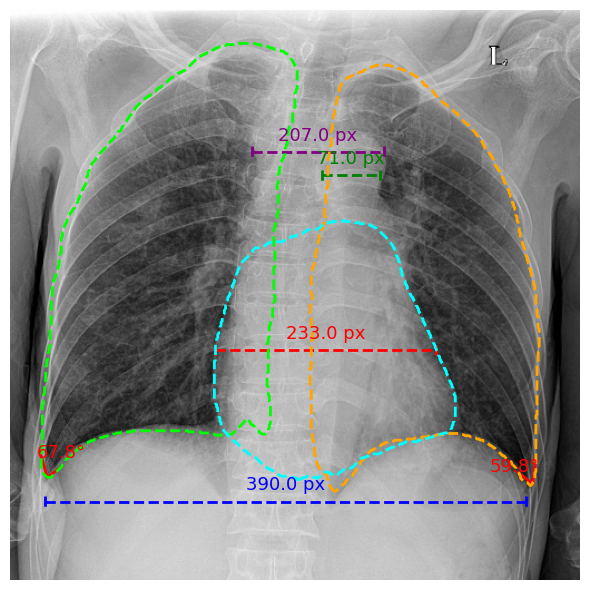

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle between three points.
    p1: intersection point
    p2: point on the lung boundary
    p3: another point on the lung boundary
    """
    vector1 = np.array(p2) - np.array(p1)
    vector2 = np.array(p3) - np.array(p1)
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)

# Assuming 'img' is the original image and 'pred' is the predicted masks
# 'img' should be a 3D numpy array (channels, height, width)
# 'pred' should be a 4D numpy array (batch, classes, height, width)

# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)

# Step 1: Calculate maximum horizontal diameters
def measure_maximum_diameter(mask):
    contours = find_contours(mask, level=0.5)
    max_diameter = 0
    for contour in contours:
        max_y, min_y = contour[:, 0].max(), contour[:, 0].min()  # Calculate max and min y-coordinates
        diameter = max_y - min_y
        if diameter > max_diameter:
            max_diameter = diameter
    return max_diameter

left_lung_mask = pred[0, 4].numpy()
right_lung_mask = pred[0, 5].numpy()
heart_mask = pred[0, 8].numpy()
aorta_mask = pred[0, 9].numpy()
diaphramatica_mask = pred[0, 10].numpy()
media_mask = pred[0, 11].numpy()

heart_max_diameter = measure_maximum_diameter(heart_mask)
lung_combined_mask = np.logical_or(left_lung_mask, right_lung_mask)
lung_max_diameter = measure_maximum_diameter(lung_combined_mask)
diaphramatica_max_diameter = measure_maximum_diameter(diaphramatica_mask)
media_max_diameter = measure_maximum_diameter(media_mask)
aorta_max_diameter = measure_maximum_diameter(aorta_mask)

# Step 2: Calculate CTR
CTR = heart_max_diameter / lung_max_diameter
MR = media_max_diameter / lung_max_diameter

print("Đường kính tim tối đa:", heart_max_diameter, "px")
print("Đường kính phổi tối đa:", lung_max_diameter, "px")
print("Đường kính trung thất tối đa:", media_max_diameter, "px")
print("Đường kính động mạch chủ tối đa:", aorta_max_diameter, "px")

print(f"Tỉ lệ trung thất (MR): {MR:.2f}")
print(f"Tỉ lệ tim ngực (CTR): {CTR:.2f}")

# Create a figure
plt.figure(figsize=(12, 6))
plt.imshow(img[0], cmap='gray')
plt.axis('off')

# Find the contours of the heart, diaphramatica, aorta, and media
heart_contours = find_contours(heart_mask, level=0.5)
diaphramatica_contours = find_contours(diaphramatica_mask, level=0.5)
aorta_contours = find_contours(aorta_mask, level=0.5)
media_contours = find_contours(media_mask, level=0.5)

# Find the bounding boxes of the heart, diaphramatica, aorta, and media
heart_y_center = (heart_contours[0][:, 0].min() + heart_contours[0][:, 0].max()) // 2
diaphramatica_y_center = (diaphramatica_contours[0][:, 0].min() + diaphramatica_contours[0][:, 0].max()) // 2
media_y_center = (media_contours[0][:, 0].min() + media_contours[0][:, 0].max()) // 2
aorta_y_center = (aorta_contours[0][:, 0].min() + aorta_contours[0][:, 0].max()) // 2

# Plot the horizontal line inside the heart, but stop at the contour
# Vẽ đường ngang bên trong trái tim, nhưng dừng lại ở đường viền
for contour in heart_contours:
    intersection_points = np.array([point for point in contour if point[0] == heart_y_center])
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=heart_y_center, color='r', linestyle='--', linewidth=2, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])
        plt.plot([x_start, x_start], [heart_y_center - 5, heart_y_center + 5], color='r', linestyle='--', linewidth=2)
        plt.plot([x_end, x_end], [heart_y_center - 5, heart_y_center + 5], color='r', linestyle='--', linewidth=2)
        plt.text(x_start + (x_end - x_start) / 2, heart_y_center - 10, f"{heart_max_diameter} px", color='r', fontsize=13, ha='center')

# Plot the horizontal line inside the diaphramatica, but stop at the contour
# Vẽ đường ngang bên trong cơ hoành, nhưng dừng lại ở đường viền
for contour in diaphramatica_contours:
    intersection_points = np.array([point for point in contour if point[0] == diaphramatica_y_center])
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=diaphramatica_y_center, color='blue', linestyle='--', linewidth=2, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])
        plt.plot([x_start, x_start], [diaphramatica_y_center - 5, diaphramatica_y_center + 5], color='blue', linestyle='--', linewidth=2)
        plt.plot([x_end, x_end], [diaphramatica_y_center - 5, diaphramatica_y_center + 5], color='blue', linestyle='--', linewidth=2)
        plt.text(x_start + (x_end - x_start) / 2, diaphramatica_y_center - 10, f"{lung_max_diameter} px", color='blue', fontsize=13, ha='center')

# Plot the horizontal line inside the aorta, but stop at the contour
# Vẽ đường ngang bên trong động mạch chủ, nhưng dừng lại ở đường viền
for contour in aorta_contours:
    intersection_points = np.array([point for point in contour if point[0] == aorta_y_center])
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=aorta_y_center, color='green', linestyle='--', linewidth=2, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])
        plt.plot([x_start, x_start], [aorta_y_center - 5, aorta_y_center + 5], color='green', linestyle='--', linewidth=2)
        plt.plot([x_end, x_end], [aorta_y_center - 5, aorta_y_center + 5], color='green', linestyle='--', linewidth=2)
        plt.text(x_start + (x_end - x_start) / 2, aorta_y_center - 10, f"{aorta_max_diameter} px", color='green', fontsize=13, ha='center')

# Plot the horizontal line inside the media, but stop at the contour
# Vẽ đường ngang bên trong trung thất, nhưng dừng lại ở đường viền
for contour in media_contours:
    intersection_points = np.array([point for point in contour if point[0] == media_y_center])
    if intersection_points.size > 0:
        x_start = max(0, int(np.min(intersection_points[:, 1])))
        x_end = min(img.shape[2], int(np.max(intersection_points[:, 1])))
        plt.axhline(y=media_y_center, color='purple', linestyle='--', linewidth=2, xmin=x_start/img.shape[2], xmax=x_end/img.shape[2])
        plt.plot([x_start, x_start], [media_y_center - 5, media_y_center + 5], color='purple', linestyle='--', linewidth=2)
        plt.plot([x_end, x_end], [media_y_center - 5, media_y_center + 5], color='purple', linestyle='--', linewidth=2)
        plt.text(x_start + (x_end - x_start) / 2, media_y_center - 10, f"{media_max_diameter} px", color='purple', fontsize=13, ha='center')


# Indices for the masks you want to combine
target_indices = [4,5]  # Indices for left lung

# Iterate through the predicted masks and combine them
for idx, i in enumerate(target_indices):
    if(i == 4):
      mask = pred[0, i]
      combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask
      # Find and plot the contours of the mask
      contours = find_contours(combined_mask, level=idx + 0.1)
      for contour in contours:
          # plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=2, color=contour_colors[idx])

          # Find the bottom right point and its neighbors
          bottom_right_idx = np.argmax(contour[:, 1] + contour[:, 0])
          point1 = contour[bottom_right_idx]  # Bottom right point
          point2 = contour[(bottom_right_idx - 25) % len(contour)]  # Adjust distance as needed
          point3 = contour[(bottom_right_idx + 25) % len(contour)]  # Adjust distance as needed


          # Calculate the angle
          angle = calculate_angle(point1, point2, point3)

          # Draw lines connecting the points
          plt.plot([point1[1], point2[1]], [point1[0], point2[0]], 'r-',linewidth=2)
          plt.plot([point1[1], point3[1]], [point1[0], point3[0]], 'r-',linewidth=2)
          # Calculate midpoints
          mid_x1, mid_y1 = (point1[1] + point2[1]) / 2, (point1[0] + point2[0]) / 2
          mid_x2, mid_y2 = (point1[1] + point3[1]) / 2, (point1[0] + point3[0]) / 2

          plt.text(mid_x2-10, mid_y2-10, f'{angle:.1f}°', color='r', fontsize=13, ha='center', va='center')

    else:
          mask = pred[0, i]
          combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask
          # Find and plot the contours of the mask
          contours = find_contours(combined_mask, level=idx + 0.1)
          for contour in contours:
              # plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=2, color=contour_colors[idx])
              # Find the bottom left point and its neighbors
              bottom_left_idx = np.argmin(contour[:, 1] - contour[:, 0])
              point4 = contour[bottom_left_idx]  # Bottom left point
              point5 = contour[(bottom_left_idx - 25) % len(contour)]  # Adjust distance as needed
              point6 = contour[(bottom_left_idx + 25) % len(contour)]  # Adjust distance as needed

              # Calculate the angle
              angle = calculate_angle(point4, point5, point6)

              # Draw lines connecting the points
              plt.plot([point4[1], point5[1]], [point4[0], point5[0]], 'r-',linewidth=2)
              plt.plot([point4[1], point6[1]], [point4[0], point6[0]], 'r-',linewidth=2)

              # Calculate midpoints
              mid_x1, mid_y1 = (point4[1] + point5[1]) / 2, (point4[0] + point5[0]) / 2
              mid_x2, mid_y2 = (point4[1] + point6[1]) / 2, (point4[0] + point6[0]) / 2

              # Add angle measurement next to the lines
              # plt.text(mid_x1, mid_y1, f'{angle:.1f}°', color='blue', fontsize=10, ha='center', va='center')
              plt.text(mid_x2+15, mid_y2-12, f'{angle:.1f}°', color='r', fontsize=13, ha='center', va='center')


# ----------------------------------------------------------------------------------------------------------
#Vẽ phân đoạn 
# Create a blank canvas to combine the masks
combined_mask = np.zeros_like(img[0], dtype=np.uint8)

# Indices for the masks you want to combine
#Vẽ phân đoạn 

target_indices = [4,5,8]  # Indices for left lung, right lung, and heart

# Custom colors for each contour
contour_colors = ['orange', 'lime', 'cyan', 'magenta', 'magenta', 'yellow', 'black', 'black',
                  'orange', 'purple', 'green', 'brown', 'gray', 'lime']

# Iterate through the predicted masks and plot each contour separately
for idx, i in enumerate(target_indices):
    mask = pred[0, i]
    combined_mask[mask > 0] = idx + 1  # Assign a unique value to each mask

    # Find and plot the contours of the mask
    contours = find_contours(combined_mask, level=idx + 0.1)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linestyle='--', linewidth=2,  color=contour_colors[idx])
#Adjust layout and show the plot
plt.tight_layout()
plt.show()